In [ ]:
import pandas as pd
import os
from google.colab import drive
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Psychologia/Magisterka/magisterka Psyche/Mateusz_Kamyczura_Praca_Magisterska/Kody/Baza danych'
Output_path = path + '/Output'

Mounted at /content/drive


In [ ]:
mat = pd.read_excel(Output_path + '/mat.xlsx')
niemat = pd.read_excel(Output_path + '/niemat.xlsx')

In [ ]:
def porownaj_grupy(df1, df2, kolumna, nazwa1='Grupa 1', nazwa2='Grupa 2'):
    def statystyki(df, kolumna):
        return {
            'Liczność': len(df),
            'Mediana': df[kolumna].median(),
            'Średnia': df[kolumna].mean(),
            'Rozstęp': df[kolumna].max() - df[kolumna].min(),
            'Odchylenie standardowe': df[kolumna].std(),
            'Skośność': stats.skew(df[kolumna]),
            'Kurtoza': stats.kurtosis(df[kolumna])
        }

    # Obliczenie statystyk dla obu grup
    statystyki_grupa1 = statystyki(df1, kolumna)
    statystyki_grupa2 = statystyki(df2, kolumna)

    # Tworzenie tabeli wyników
    wynik = pd.DataFrame([statystyki_grupa1, statystyki_grupa2], index=[nazwa1, nazwa2])

    return wynik

In [ ]:
porownaj_grupy(mat, niemat, 'ProcentPoprawnych',"Matematycy", "Niematematycy")

,Liczność,Mediana,Średnia,Rozstęp,Odchylenie standardowe,Skośność,Kurtoza
Matematycy,42,71.428571,74.283109,53.571429,14.675364,0.060685,-1.054089
Niematematycy,41,73.333333,74.942519,57.142857,14.034167,-0.119764,-0.759075


In [ ]:

def test_normalnosci_i_t(df1, df2, kolumna, nazwa1="Grupa 1", nazwa2="Grupa 2"):
    print("=== Testy wstępne ===")

    # Test Shapiro-Wilka dla normalności
    stat1 = stats.shapiro(df1[kolumna])
    stat2 = stats.shapiro(df2[kolumna])
    p1 = stat1.pvalue
    p2 = stat2.pvalue

    print(f"{nazwa1} - Shapiro-Wilk: p = {p1:.4f} → {'normalny' if p1 > 0.05 else 'nienormalny'}")
    print(f"{nazwa2} - Shapiro-Wilk: p = {p2:.4f} → {'normalny' if p2 > 0.05 else 'nienormalny'}")

    # Test Levene’a na jednorodność wariancji
    levene = stats.levene(df1[kolumna], df2[kolumna])
    print(f"\nTest Levene’a (jednorodność wariancji): F = {levene.statistic:.2f}, p = {levene.pvalue:.4f} → {'jednorodne' if levene.pvalue > 0.05 else 'niejednorodne'}")

    # Czy dane są normalne?
    normalne = p1 > 0.05 and p2 > 0.05

    # Jeśli nie, sprawdzamy kurtozę i skośność
    if not normalne:
        print("\nRozkłady nie są normalne. Sprawdzamy kurtozę i skośność jako dodatkowe kryteria:")
        sk1 = skew(df1[kolumna])
        sk2 = skew(df2[kolumna])
        kurt1 = kurtosis(df1[kolumna])
        kurt2 = kurtosis(df2[kolumna])

        print(f"{nazwa1} - skośność = {sk1:.2f}, kurtoza = {kurt1:.2f}")
        print(f"{nazwa2} - skośność = {sk2:.2f}, kurtoza = {kurt2:.2f}")

        if all(abs(val) <= 1 for val in [sk1, sk2]) and all(abs(val) <= 2 for val in [kurt1, kurt2]):
            print("Skośność i kurtoza są w akceptowalnym zakresie → dopuszczamy test t.")
            normalne = True
        else:
            print("Skośność lub kurtoza przekraczają dopuszczalne wartości → nie przeprowadzamy testu t.")

    # Jeśli wszystko gra – robimy test t
    if normalne:
        equal_var = levene.pvalue > 0.05
        test_t = stats.ttest_ind(df1[kolumna], df2[kolumna], equal_var=equal_var)
        test_t_result = f"Test t-Studenta ({nazwa1} vs {nazwa2}): statystyka = {test_t.statistic:.4f}, p = {test_t.pvalue:.4f} → {'istotna różnica' if test_t.pvalue < 0.05 else 'brak istotnej różnicy'}"

        # Obliczanie Cohen's d
        mean1 = df1[kolumna].mean()
        mean2 = df2[kolumna].mean()
        std1 = df1[kolumna].std(ddof=1)
        std2 = df2[kolumna].std(ddof=1)
        n1 = len(df1[kolumna])
        n2 = len(df2[kolumna])
        pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))
        cohens_d = (mean1 - mean2) / pooled_std

        print("\n=== Wynik testu t ===")
        print(test_t_result)
        print(f"Cohen's d = {cohens_d:.2f} → {'mały' if abs(cohens_d) < 0.2 else 'średni' if abs(cohens_d) < 0.8 else 'duży'} efekt")

    else:
        test_t_result = "Nie przeprowadzono testu t (dane niespełniają założeń)."
        cohens_d = None

    return {
        f"Shapiro-Wilk p {nazwa1}": p1,
        f"Shapiro-Wilk p {nazwa2}": p2,
        "Levene p": levene.pvalue,
        "Test t wynik": test_t_result,
        "Cohen's d": cohens_d
    }


In [ ]:
test_normalnosci_i_t(mat, niemat, 'ProcentPoprawnych', "Matematycy", "Niematematycy")

=== Testy wstępne ===
Matematycy - Shapiro-Wilk: p = 0.0437 → nienormalny
Niematematycy - Shapiro-Wilk: p = 0.6023 → normalny

Test Levene’a (jednorodność wariancji): F = 0.13, p = 0.7177 → jednorodne

Rozkłady nie są normalne. Sprawdzamy kurtozę i skośność jako dodatkowe kryteria:
Matematycy - skośność = 0.06, kurtoza = -1.05
Niematematycy - skośność = -0.12, kurtoza = -0.76
Skośność i kurtoza są w akceptowalnym zakresie → dopuszczamy test t.

=== Wynik testu t ===
Test t-Studenta (Matematycy vs Niematematycy): statystyka = -0.2091, p = 0.8349 → brak istotnej różnicy
Cohen's d = -0.05 → mały efekt


{'Shapiro-Wilk p Matematycy': np.float64(0.043659094917544286),
 'Shapiro-Wilk p Niematematycy': np.float64(0.6023425706092758),
 'Levene p': np.float64(0.7177115874821016),
 'Test t wynik': 'Test t-Studenta (Matematycy vs Niematematycy): statystyka = -0.2091, p = 0.8349 → brak istotnej różnicy',
 "Cohen's d": np.float64(-0.045912557367963895)}

In [ ]:

def narysuj_histogram_boczny_z_kde(df1, df2, kolumna, nazwa1="Grupa 1", nazwa2="Grupa 2", bins=20):
    """
    Rysuje histogram z podziałem na dwie grupy, słupki obok siebie + KDE.

    Argumenty:
    - df1, df2: DataFrame’y z daną kolumną
    - kolumna: kolumna do porównania
    - nazwa1, nazwa2: etykiety grup
    - bins: liczba słupków
    """
    plt.figure(figsize=(10, 6))

    # Dane
    dane1 = df1[kolumna].dropna()
    dane2 = df2[kolumna].dropna()

    # Wspólne biny
    all_data = np.concatenate([dane1, dane2])
    counts1, bin_edges = np.histogram(dane1, bins=bins, range=(all_data.min(), all_data.max()))
    counts2, _ = np.histogram(dane2, bins=bin_edges)

    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2

    # Przesuwamy słupki
    offset = bin_width / 4
    plt.bar(bin_centers - offset, counts1 / len(dane1), width=bin_width/2, label=nazwa1, color='skyblue', alpha=0.7)
    plt.bar(bin_centers + offset, counts2 / len(dane2), width=bin_width/2, label=nazwa2, color='salmon', alpha=0.7)

    # KDE
    kde1 = gaussian_kde(dane1)
    kde2 = gaussian_kde(dane2)
    x = np.linspace(all_data.min(), all_data.max(), 500)
    plt.plot(x, kde1(x), color='blue', linestyle='--', label=f"KDE - {nazwa1}")
    plt.plot(x, kde2(x), color='red', linestyle='--', label=f"KDE - {nazwa2}")

    #plt.title(f"Histogram porównawczy procenta poprawnych rozpoznań z KDE")
    plt.xlabel("Procent poprawnych rozpoznań")
    plt.ylabel("Liczba obserwacji (znormalizowana)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


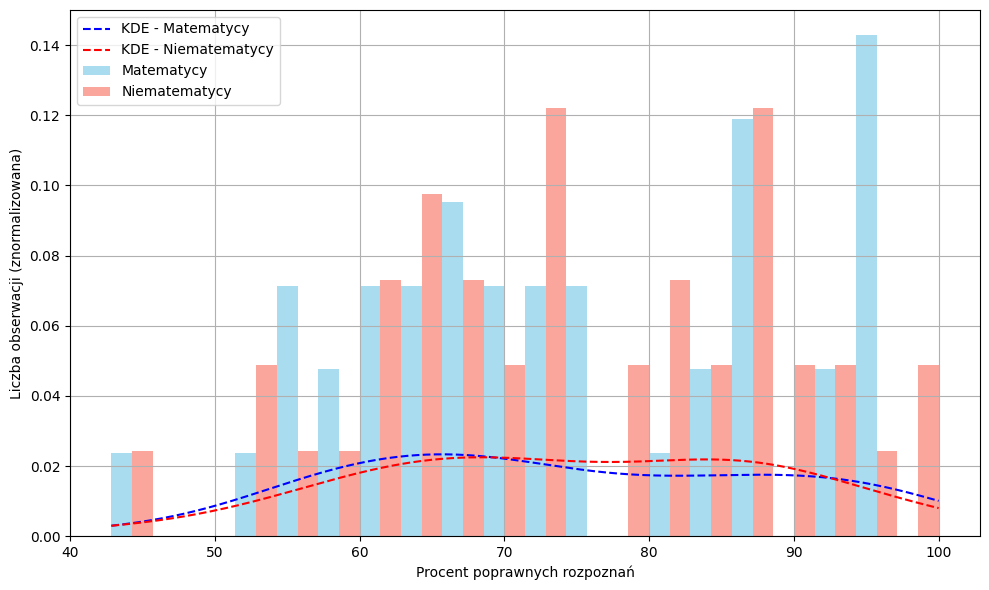

In [ ]:
narysuj_histogram_boczny_z_kde(mat, niemat, "ProcentPoprawnych", "Matematycy", "Niematematycy")